## InvestOps Tutorial - Portfolio Group Constraints

[Original repository on GitHub](https://github.com/Hvass-Labs/InvestOps-Tutorials)

Original author is [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)

----

"*How many bacon rolls you're wantings Sir, we don't have so much bacons!*" - [Facejacker](https://www.youtube.com/watch?v=wKmhJFwwiSM)

## Introduction

One way of controlling risk in an investment portfolio, is to ensure that it is diversified in many different groups of assets, such as stocks, bonds, currencies and commodities, and across many different countries, industries, credit-ratings, etc.

This tutorial shows how to adjust the portfolio weights according to the groups that the assets belong to, so the entire groups of assets are within some constraints or limits. This is an easy problem if all the groups are mutually exclusive, but the problem is much more complicated when assets may belong to many overlapping groups.

For classic "mean-variance" portfolio optimization, the group constraints are solved as an integral part of the optimization problem. But when we are using another portfolio method such as the "filter-diversify" method, we need a separate method for adjusting the portfolio weights so they satisfy the group constraints. This tutorial shows how to use a very efficient algorithm for doing this.

The paper referenced below gives a detailed explanation of the algorithm and how it works.

## References <a id="refs"></a>

- M.E.H. Pedersen, "*Portfolio Group Constraints*", 2022. ([PDF](https://ssrn.com/abstract=4033243))

## Google Colab

In [1]:
# If running in Google Colab, automatically install the required
# Python packages. This is NOT recommended on your local computer,
# unless you have setup a Python environment for this project.
# See the README on GitHub for detailed instructions.
if 'google.colab' in str(get_ipython()):
    !pip install investops numpy pandas matplotlib

## Imports

In [2]:
%matplotlib inline

In [3]:
# Python packages.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
# InvestOps.
import investops as iv
from investops.group_constraints import GroupConstraints
from investops.random import (rand_normal, rand_uniform,
                              rand_where, rand_groups,
                              gen_asset_names, gen_group_names)

In [5]:
# InvestOps version.
iv.__version__

'0.3.0'

## Config

In [6]:
# Random number generator.
# The seed makes the experiments repeatable.
rng = np.random.default_rng(seed=80085)

## Small Example - Positive Weights

This small example has 3 different groups named: Group A, B, and C, which could be different asset classes (stocks, bonds, commodities), or it could be different countries or industries. We then have 4 different assets named: Asset 1, 2, 3, and 4, which could be different bonds, stocks, etc. In this small example all the portfolio weights are positive.

In [7]:
# The individual group-names.
GROUP_A = 'Group A'
GROUP_B = 'Group B'
GROUP_C = 'Group C'

# List of all the group-names.
group_names = [GROUP_A, GROUP_B, GROUP_C]

In [8]:
# The individual asset-names.
ASSET_1 = 'Asset 1'
ASSET_2 = 'Asset 2'
ASSET_3 = 'Asset 3'
ASSET_4 = 'Asset 4'

# List of all the asset-names.
asset_names = [ASSET_1, ASSET_2, ASSET_3, ASSET_4]

In [9]:
# This data-structure defines the association between assets
# and groups. It is a dictionary of lists, so it enables us to
# lookup the list of groups that are associated with an asset-name.
asset_to_groups = \
{
    # Groups that Asset 1 belongs to.
    ASSET_1: [GROUP_A],
    
    # Groups that Asset 2 belongs to.
    ASSET_2: [GROUP_A, GROUP_B],
    
    # Groups that Asset 3 belongs to.
    ASSET_3: [GROUP_B, GROUP_C],
    
    # Groups that Asset 4 belongs to.
    ASSET_4: [GROUP_C],
}

In [10]:
# Group-limits for the POSITIVE portfolio weights.
# This must be a Pandas Series so the groups are named properly.
group_lim_pos = {GROUP_A: 0.05, GROUP_B: 0.1, GROUP_C: 0.2}
group_lim_pos = pd.Series(group_lim_pos)

# We do not use group-limits for the NEGATIVE portfolio weights.
group_lim_neg = None

In [11]:
# Original portfolio weights found through some other process,
# e.g. by estimating the future asset-returns and use them to
# determine how much of the portfolio to invest in each asset.
weights_org = {ASSET_1: 0.05, ASSET_2: 0.1, ASSET_3: 0.15, ASSET_4: 0.2}
weights_org = pd.Series(weights_org)

In [12]:
# Initialize the solver for the Group Constraints.
# This sets up internal data-structures for efficiently solving
# the problem. If you later change the asset-names, group-names,
# group-limits, or the mapping from assets to lists of groups,
# then you must create a new instance of this solver.
grp = GroupConstraints(asset_names=asset_names,
                       group_names=group_names,
                       asset_to_groups=asset_to_groups,
                       group_lim_pos=group_lim_pos,
                       group_lim_neg=group_lim_neg)

In [13]:
# Calculate the adjusted weights that satisfy the group constraints.
weights_new = grp.constrain_weights(weights_org=weights_org)
weights_new

Asset 1    0.016667
Asset 2    0.033333
Asset 3    0.065788
Asset 4    0.134212
dtype: float64

In [14]:
# Calculate the adjusted weights that satisfy the group constraints.
# This logs the adjusted weights for all iterations of the algorithm.
# Note that it is significantly slower to log all results, so this
# should only be done for testing / debugging purposes, and not for
# an actual trading or back-testing-system.
weights_new_log = grp.constrain_weights(weights_org=weights_org,
                                        log=True)
weights_new_log

,Asset 1,Asset 2,Asset 3,Asset 4
0,0.050000,0.100000,0.150000,0.200000
1,0.016667,0.033333,0.060000,0.114286
2,0.016667,0.033333,0.064286,0.131148
3,0.016667,0.033333,0.065788,0.134212
4,0.016667,0.033333,0.065788,0.134212


In [15]:
# Calculate the group-ratios between the group-limits / group-sums,
# which are less than 1.0 if the group-sums are too high so the
# portfolio weights must be decreased. And the group-ratios are
# greater than 1.0 if the group-sums are lower than the group-limits,
# so the portfolio weights could be increased. Ideally we want all
# the group limits to be equal or slightly above 1.0, as those weights
# satisfy all the group constraints while being the closest possible
# to the original portfolio weights.
group_ratios_pos, group_ratios_neg = grp.group_ratios(weights=weights_new_log)
group_ratios_pos

,Group A,Group B,Group C
0,0.333333,0.400000,0.571429
1,1.000000,1.071429,1.147541
2,1.000000,1.024390,1.023367
3,1.000000,1.008866,1.000000
4,1.000000,1.008866,1.000000


## Small Example - Positive & Negative Weights

This is another small example again using 3 groups and 4 assets, but this time some of the original portfolio weights are positive and some are negative.

In [16]:
# Group-limits for the POSITIVE portfolio weights.
group_lim_pos = {GROUP_A: 0.05, GROUP_B: 0.1, GROUP_C: 0.2}
group_lim_pos = pd.Series(group_lim_pos)

# Group-limits for the NEGATIVE portfolio weights.
# These must all be negative values. Note the -np.inf which
# indicates that there is no negative limit for Group A.
group_lim_neg = {GROUP_A: -np.inf, GROUP_B: -0.15, GROUP_C: -0.1}
group_lim_neg = pd.Series(group_lim_neg)

In [17]:
# Original portfolio weights.
weights_org = {ASSET_1: -0.05, ASSET_2: -0.1, ASSET_3: -0.15, ASSET_4: 0.2}
weights_org = pd.Series(weights_org)

In [18]:
# Initialize the solver for the Group Constraints.
grp = GroupConstraints(asset_names=asset_names,
                       group_names=group_names,
                       asset_to_groups=asset_to_groups,
                       group_lim_pos=group_lim_pos,
                       group_lim_neg=group_lim_neg)

In [19]:
# Calculate the adjusted weights that satisfy the group constraints.
weights_new = grp.constrain_weights(weights_org=weights_org)
weights_new

Asset 1   -0.05
Asset 2   -0.06
Asset 3   -0.09
Asset 4    0.20
dtype: float64

In [20]:
# Calculate and log the adjusted weights satisfying the constraints.
weights_new_log = grp.constrain_weights(weights_org=weights_org, log=True)
weights_new_log

,Asset 1,Asset 2,Asset 3,Asset 4
0,-0.05,-0.10,-0.15,0.2
1,-0.05,-0.06,-0.09,0.2
2,-0.05,-0.06,-0.09,0.2


In [21]:
# Calculate the group-ratios between the group-limits / group-sums.
# Note that a group-ratio of inf (infinity) means that either
# the group-limit was inf, or the group-sum was zero. The goal
# is still to have the non-inf group-ratios be equal to 1.0 or
# slightly above.
group_ratios_pos, group_ratios_neg = grp.group_ratios(weights=weights_new_log)
group_ratios_pos

,Group A,Group B,Group C
0,inf,inf,1.0
1,inf,inf,1.0
2,inf,inf,1.0


In [22]:
# Show group-ratios for the negative portfolio weights.
group_ratios_neg

,Group A,Group B,Group C
0,inf,0.6,0.666667
1,inf,1.0,1.111111
2,inf,1.0,1.111111


## Big Example

We will now consider a much larger example of 1000 assets and 20 groups, where we will generate random data for the portfolio.

In [23]:
# Number of assets.
num_assets = 1000

# Number of groups.
num_groups = 20

# Min number of groups per asset.
min_groups_per_asset = 1

# Max number of groups per asset.
max_groups_per_asset = 10

In [24]:
# List of asset-names.
asset_names = gen_asset_names(num_assets=num_assets)

# List of group-names.
group_names = gen_group_names(num_groups=num_groups)

In [25]:
# Generate a random data-structure for the associations between
# assets and groups. This is a dict where each asset-name maps
# to a list of group-names.
asset_to_groups = \
    rand_groups(rng=rng, num_assets=num_assets, num_groups=num_groups,
                max_groups_per_asset=max_groups_per_asset,
                min_groups_per_asset=min_groups_per_asset,
                asset_names=asset_names, group_names=group_names)

In [26]:
# Random POSITIVE group-limits.
group_lim_pos = \
    rand_uniform(rng=rng, index=group_names, low=0.05, high=0.2)

# Random NEGATIVE group-limits.
group_lim_neg = \
    rand_uniform(rng=rng, index=group_names, low=-0.2, high=-0.05)

In [27]:
# Randomly set some of the group-limits to infinity.
prob = 0.05
group_lim_pos = rand_where(rng=rng, x=group_lim_pos, y=np.inf, prob=prob)
group_lim_neg = rand_where(rng=rng, x=group_lim_neg, y=-np.inf, prob=prob)

In [28]:
# Random normal-distributed portfolio weights.
weights_org = \
    rand_normal(rng=rng, index=asset_names,
                mean=0.0, std=0.005, low=-1, high=1)

In [29]:
# Initialize the solver for the Group Constraints.
grp = GroupConstraints(asset_names=asset_names,
                       group_names=group_names,
                       asset_to_groups=asset_to_groups,
                       group_lim_pos=group_lim_pos,
                       group_lim_neg=group_lim_neg)

In [30]:
# Calculate the adjusted weights that satisfy the group constraints.
weights_new = grp.constrain_weights(weights_org=weights_org)
weights_new.head()

Asset 0   -0.000363
Asset 1   -0.001215
Asset 2    0.001506
Asset 3    0.000975
Asset 4   -0.000295
dtype: float64

In [31]:
# Calculate and log the adjusted weights satisfying the constraints.
weights_new_log = grp.constrain_weights(weights_org=weights_org, log=True, max_iter=20)
weights_new_log.head()

,Asset 0,Asset 1,Asset 2,Asset 3,Asset 4,Asset 5,Asset 6,Asset 7,Asset 8,Asset 9,...,Asset 990,Asset 991,Asset 992,Asset 993,Asset 994,Asset 995,Asset 996,Asset 997,Asset 998,Asset 999
0,-0.002703,-0.004127,0.010289,0.006664,-0.001953,0.001291,-0.005768,-0.001640,0.006948,0.003853,...,0.011102,-0.004603,-0.004553,-0.005925,-0.000146,-0.007903,-0.003832,0.004990,-0.002788,0.002863
1,-0.000338,-0.000695,0.001461,0.000946,-0.000256,0.000161,-0.001116,-0.000215,0.001892,0.000549,...,0.001760,-0.001179,-0.000570,-0.000801,-0.000032,-0.002780,-0.000384,0.001139,-0.000366,0.000406
2,-0.000358,-0.000899,0.001497,0.000970,-0.000281,0.000161,-0.001620,-0.000236,0.003382,0.000564,...,0.001976,-0.002194,-0.000602,-0.000881,-0.000052,-0.006799,-0.000384,0.001699,-0.000401,0.000417
3,-0.000362,-0.001031,0.001504,0.000974,-0.000290,0.000161,-0.002029,-0.000244,0.005282,0.000567,...,0.002131,-0.003326,-0.000610,-0.000909,-0.000072,-0.007903,-0.000384,0.002235,-0.000415,0.000419
4,-0.000363,-0.001111,0.001505,0.000975,-0.000293,0.000161,-0.002331,-0.000247,0.006948,0.000568,...,0.002251,-0.004324,-0.000611,-0.000919,-0.000089,-0.007903,-0.000384,0.002676,-0.000420,0.000419


We will now plot the weight-ratios and group-ratios. These show how the weight- and group-ratios evolve through the iterations of the algorithm. In the first iteration all the weights are decreased massively in order to satisfy the group-constraints, so the group-sums are all smaller than their respective group-limits. But this is an over-adjustment of the portfolio weights, so in the following iterations, the portfolio weights are gradually increased as the group-sums get closer and closer to the group-limits, while the adjusted weights must still be smaller or equal to the original weights.

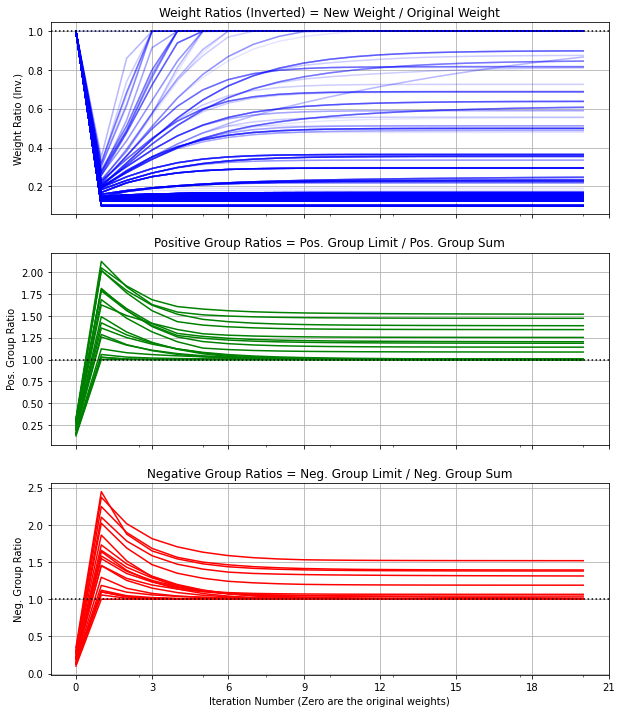

In [32]:
# Create a figure with the log's weight-ratios and group-ratios.
fig = grp.plot_log(weights_org=weights_org,
                   weights_new_log=weights_new_log)

# Save the figure to a file.
fig.savefig('Portfolio Log.svg')

# Show the figure here.
fig;

## Time Usage

We will now see how long it takes to initialize the solver and run the algorithm. This uses the same random data from above with 1000 assets and 20 groups. So this is a very large portfolio. As can be seen, it only takes around 6 milli-seconds to initialize the solver, and then it takes around 2-3 milli-seconds to run the algorithm, or 13 milli-seconds if we want to log all the intermediate results of the algorithm.

Also note that a pure Python implementation needs around 100 milli-seconds to run the exact same algorithm that only takes 2-3 milli-seconds here, so the Numba Jit compiler provides a 40-50 times speed-up over pure Python.

In [33]:
%%timeit
# Time-usage for initializing the solver.
GroupConstraints(asset_names=asset_names,
                 group_names=group_names,
                 asset_to_groups=asset_to_groups,
                 group_lim_pos=group_lim_pos,
                 group_lim_neg=group_lim_neg)

6.22 ms ± 646 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [34]:
# Time-usage for the group-constraint algorithm.
%timeit grp.constrain_weights(weights_org=weights_org)

2.44 ms ± 127 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [35]:
# Time-usage for the group-constraint algorithm with logging.
# Note: It is not the logging that is time-consuming, but the
# automated checking that all the intermediate results in the
# log are valid and satisfy all the constraints.
%timeit grp.constrain_weights(weights_org=weights_org, log=True)

13.8 ms ± 303 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Minimum Group Constraints

The algorithm only enforces upper limits for the group constraints. If you want to ensure a minimum part of your portfolio is invested in a group, then the easiest way is to set all the portfolio weights within that group to the max weight you want to allow for a single asset. The algorithm does not guarantee that the group-sum is above the lower limit because that may not be a valid solution, but the algorithm will find the best compromise.

## License (MIT)

This is published under the [MIT License](https://github.com/Hvass-Labs/InvestOps-Tutorials/blob/main/LICENSE) which allows very broad use for both academic and commercial purposes.

You are very welcome to modify and use this source-code in your own project. Please keep a link to the [original repository](https://github.com/Hvass-Labs/InvestOps-Tutorials).